# RiskSense: Application clustering algorithm based on their credit risk 

RiskSense is a risk encoding and clustering model specifically designed to transform the way financial institutions assess and cluster applications based on their risk profiles. By leveraging advanced techniques such as data encoding using Keras and subsequent application of K-means clustering, RiskSense offers a powerful solution for effectively analyzing and categorizing applications into low risk, medium risk, and high risk categories.

Through sophisticated neural network architectures, RiskSense captures intricate patterns and risk factors present in application data, transforming raw data into meaningful encoded representations. This encoding process enables a comprehensive understanding of the underlying risk factors associated with each application.

Once the data has been encoded, RiskSense employs the K-means clustering algorithm to group applications based on their risk profiles. By analyzing the encoded representations, RiskSense partitions the applications into distinct clusters, enabling financial institutions to differentiate applications according to their risk levels. This clustering process facilitates efficient decision-making and resource allocation, empowering institutions to effectively manage and mitigate risks.

The advantages of RiskSense are manifold. The data encoding step using Keras enables the model to capture complex risk patterns that may be challenging to identify using traditional approaches. Leveraging the power of deep learning, RiskSense extracts high-level representations from raw application data, providing a comprehensive understanding of the underlying risk factors.

Furthermore, the integration of K-means clustering allows RiskSense to group applications into meaningful risk categories. This categorization empowers financial institutions to prioritize their resources and tailor their risk mitigation strategies accordingly. By efficiently allocating resources and focusing on higher-risk applications, institutions can enhance their risk management strategies and make informed decisions that balance risk and reward.

![Image Description](https://images.pexels.com/photos/5849563/pexels-photo-5849563.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2)

**Using a combination of Keras encoding and K-means clustering for application risk profiling offers several advantages**

* Non-linear Feature Transformations: Keras encoding facilitates non-linear transformations of the input features. In many cases, application data may exhibit non-linear relationships between the various risk factors. By using deep learning techniques, RiskSense can capture these non-linear relationships and create encoded representations that preserve the complex interactions among the features. This capability allows for a more accurate and nuanced representation of the risk factors, leading to improved clustering results.

* K-means Clustering for Risk Categorization: K-means clustering is a well-established and widely used unsupervised learning algorithm for partitioning data into distinct clusters. After the Keras encoding step, RiskSense applies K-means clustering on the encoded representations to group similar applications together based on their risk profiles. K-means clustering offers simplicity, scalability, and interpretability, making it a suitable choice for risk categorization. The resulting clusters allow financial institutions to differentiate applications into low risk, medium risk, and high risk categories, facilitating effective resource allocation and decision-making.

While other methods for risk profiling and clustering exist, combining Keras encoding with K-means clustering offers a powerful and flexible approach. Other methods, such as traditional feature engineering followed by clustering algorithms like hierarchical clustering or DBSCAN, may require more manual effort and may not capture the complex risk patterns as effectively. The Keras encoding and K-means clustering approach provides a comprehensive solution that leverages the advantages of deep learning and unsupervised learning, enabling accurate and efficient application risk profiling.

In [7]:
""" Importing modules """
import helpers
import pandas as pd
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

warnings.filterwarnings("ignore")

In [8]:
""" Reading the application dataset """
df_application = pd.read_csv("home_credit_risk/application_train.csv")

In [3]:
""" Getting missing columns """
missing_columns = [
    col for col, val in df_application.isnull().sum().items() if val != 0
]

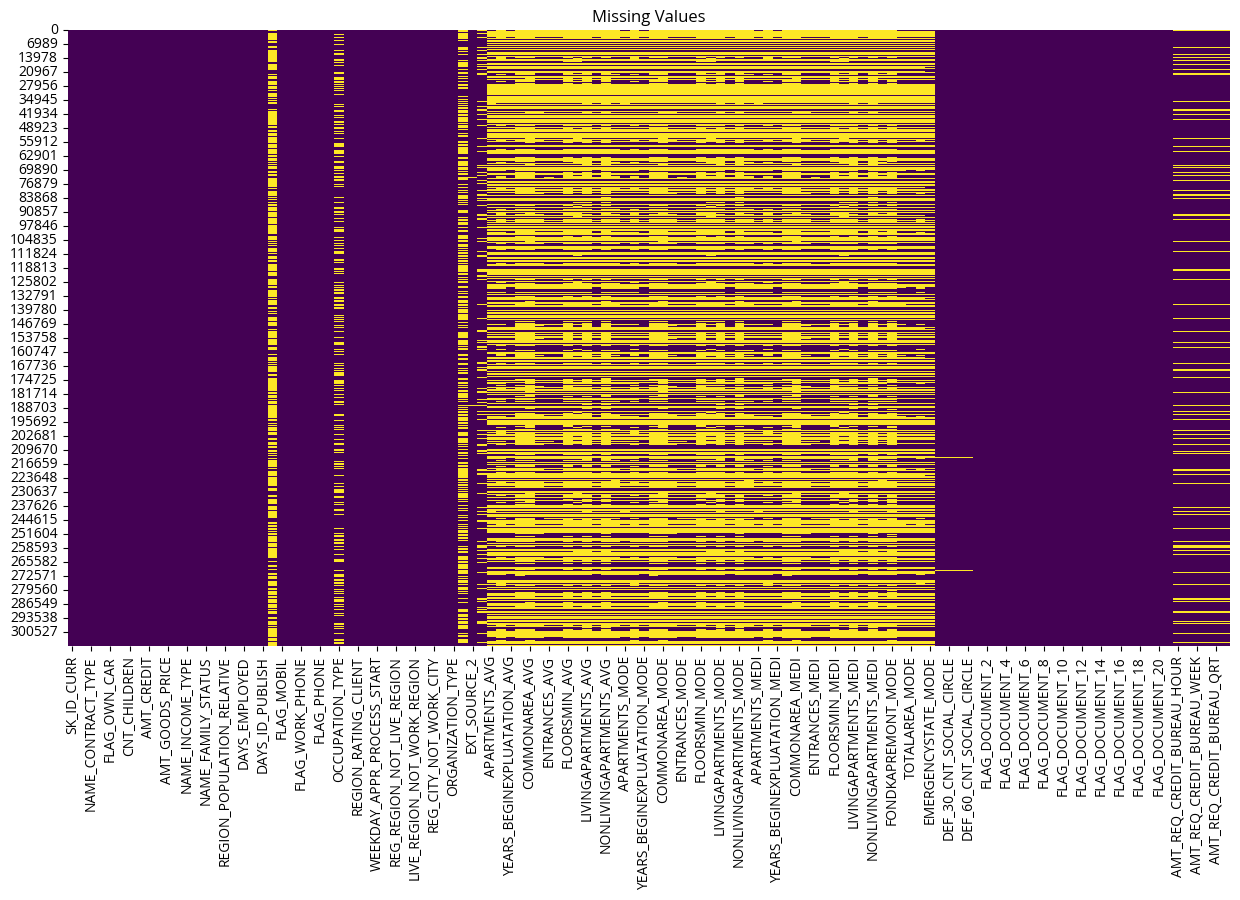

In [4]:
""" Printing out missing values  """
helpers.plot_missing_vals(df_application, missing_columns)

### Data Cleaning

First, I start with data cleaning.

I saw that there are some mismatches in the categorical data. For instance in CODE_GENDER and FONDKAPREMONT_MODE columns.

Fixing gender values:

* df_application['CODE_GENDER'].replace('XNA', np.nan) replaces all occurrences of the string 'XNA' in the 'CODE_GENDER' column of the DataFrame with np.nan, which represents a missing value. This operation intends to handle cases where the gender is unknown or unspecified, replacing them with NaN values. By doing this, the code removes any instances where 'XNA' is used as a gender value in the 'CODE_GENDER' column.

Setting to None not specific values of FONDKAPREMONT_MODE:

* df_application['FONDKAPREMONT_MODE'].replace('not specified', np.nan) replaces all occurrences of the string 'not specified' in the 'FONDKAPREMONT_MODE' column of the DataFrame with np.nan. This operation intends to handle cases where the 'FONDKAPREMONT_MODE' column contains a value that is not specified or not applicable. By replacing 'not specified' with NaN, the code treats those values as missing values, allowing for easier analysis or handling of such cases.

In [9]:
""" Fixing gender values """
df_application["CODE_GENDER"] = df_application["CODE_GENDER"].replace("XNA", np.nan)

""" Setting to None not specific values of FONDKAPREMONT_MODE """
df_application["FONDKAPREMONT_MODE"] = df_application["FONDKAPREMONT_MODE"].replace(
    "not specified", np.nan
)

Also, some other categorical columns have None as a value, therefore if there exists np.nan type of that column, I will impute them with that value "None"

In [6]:
""" Getting columns that will be imputed with None """
fill_by_None = [
    "OCCUPATION_TYPE",
    "HOUSETYPE_MODE",
    "WALLSMATERIAL_MODE",
    "FONDKAPREMONT_MODE",
]

In [7]:
""" Taking columns that I will impute with zero because they are either average, medium or mode values """
replace_by_zero = []
for col in df_application.columns:
    if col in df_application.columns:
        if df_application[col].dtype not in [str, object]:
            if col.endswith("MEDI") or col.endswith("MODE") or col.endswith("AVG"):
                replace_by_zero.append(col)
replace_by_zero = set(
    replace_by_zero
    + [
        col
        for col in helpers.known_replace_by_zero_cols
        if col in df_application.columns
    ]
)

The function **find_missing_data_patterns** aims to identify patterns of missing data in the specified numeric columns of the DataFrame. It does this by sampling 1000 rows from the DataFrame and iterating over the specified columns.

For each column, it creates an empty list called missing_pattern and identifies the rows where the column's value is missing (NaN or null) using the isnull() function. If the number of missing rows for a column is greater than 10000, it proceeds to analyze the missing patterns.

For each missing row, it identifies the columns that have missing values using df.loc[row].isnull() and converts them to a list using index.tolist(). It then selects the rows from the DataFrame where all the missing columns have missing values using df[df[missing_cols].isna().all(axis=1)]. If the number of missing columns is greater than 1 and the number of selected rows is equal to the number of missing rows, it extends the missing_pattern list with the unique missing columns.

Finally, if the length of missing_pattern is greater than 1, it adds the unique missing columns to the missing_patterns list.

The function returns a list of missing data patterns, where each pattern is a list of unique missing columns.

In [8]:
""" Creating missing columns pattern list """
missing_patterns = helpers.find_missing_data_patterns(
    df_application,
    [col for col in missing_columns if df_application[col].dtype == float],
)

### Creating clustering model

In [9]:
""" Splitting dataset into train and validation """
data = df_application.copy()
features = data.drop("TARGET", axis=1)
target = data["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, stratify=target
)
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [12]:
""" Getting preprocessing pipeline """
final_preprocessor = helpers.get_final_application_preprocessor_pipeline(
    helpers.get_application_cleaner(
        X_train, missing_patterns, fill_by_None, replace_by_zero
    ),
    list(X_train.columns),
)
final_preprocessor

Pipeline(steps=[('cleaner',
                 Pipeline(steps=[('missing_cols_cleaner_0',
                                  Pipeline(steps=[('pattern_imputer',
                                                   ColumnTransformer(remainder='passthrough',
                                                                     transformers=[('pattern_impute',
                                                                                    Pipeline(steps=[('missing_mask',
                                                                                                     <helpers.MissingMaskTransformer object at 0x3234884c0>),
                                                                                                    ('imputer',
                                                                                                     SimpleImputer(fill_value=-999,
                                                                                                                   strategy='constant')),
                                                                                                    ('imputer_none',
                                                                                                     SimpleIm...
                                                           'NAME_INCOME_TYPE',
                                                           'NAME_EDUCATION_TYPE',
                                                           'NAME_FAMILY_STATUS',
                                                           'NAME_HOUSING_TYPE',
                                                           'REGION_POPULATION_RELATIVE',
                                                           'DAYS_BIRTH',
                                                           'DAYS_EMPLOYED',
                                                           'DAYS_REGISTRATION',
                                                           'DAYS_ID_PUBLISH',
                                                           'OWN_CAR_AGE',
                                                           'FLAG_MOBIL',
                                                           'FLAG_EMP_PHONE',
                                                           'FLAG_WORK_PHONE',
                                                           'FLAG_CONT_MOBILE',
                                                           'FLAG_PHONE', ...])),
                ('prefixes_removal',
                 FunctionTransformer(func=<function rename_columns at 0x108af0700>))])

In [13]:
""" Transforming dataset """
X_train_transformed = final_preprocessor.fit_transform(X_train)

This function below perform_keras_encode_data 
  
* Creates an input layer for the autoencoder with the specified input dimension.
* Adds a dense layer to the model, with the encoding dimension as the number of units and ReLU activation function.
* Adds another dense layer to the model, with the input dimension as the number of units and sigmoid activation function. This layer represents the decoding part of the autoencoder.
* Constructs the autoencoder model by defining the input and output layers.
* Compiles the autoencoder model using the Adam optimizer and mean squared error (MSE) as the loss function.
* Trains the autoencoder model using the fit method on the input data. The model is trained to reconstruct the input data itself, as data is passed as both the input and target.
* Creates an encoder model by specifying the input and encoded layers.
* Returns both the trained autoencoder and the predictions of the encoder model on the input data (encoder.predict(data)).

In summary, this function builds an autoencoder model using Keras, trains it on the input data, and returns the trained autoencoder along with the encoded representations of the input data.

In [14]:
""" Performing keras encoding data """
encoder_model, encoded_data = helpers.perform_keras_encode_data(
    X_train_transformed[["CREDIT_INCOME_PERCENT", "ANNUITY_INCOME_PERCENT"]]
)

6727/6727 [==============================] - 42s 6ms/step


The optimal number of clusters is: 3


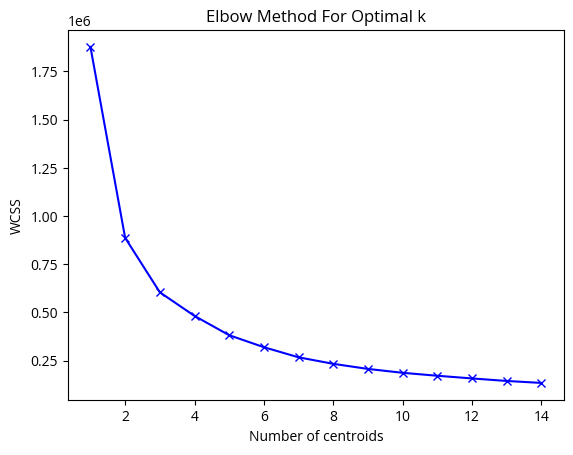

In [15]:
""" Getting best number of clusters for KMeans """
n_clusters = helpers.plot_K_means_elbow(encoded_data)

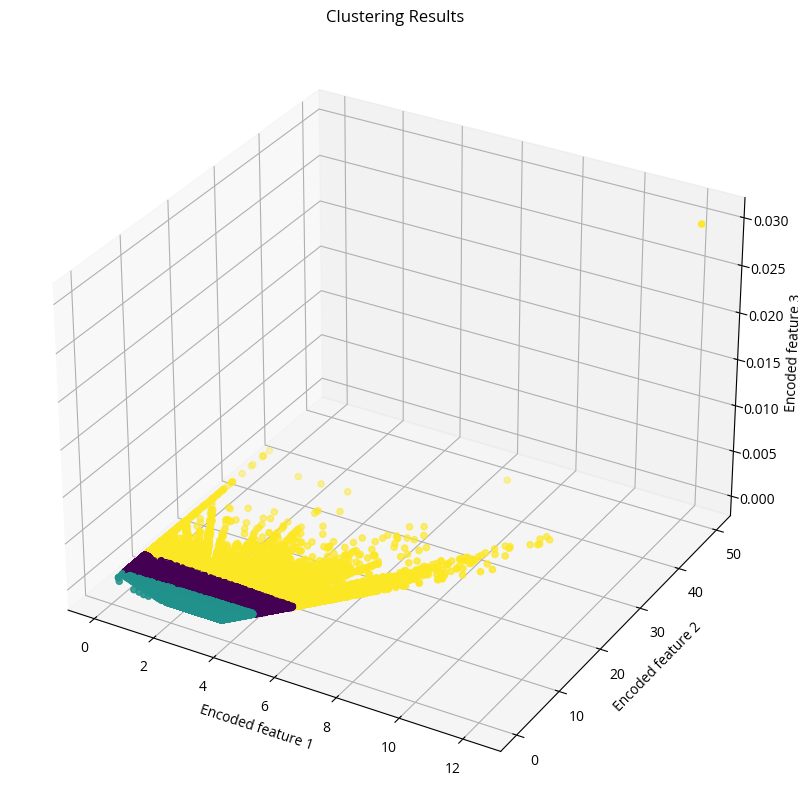

In [16]:
""" Plotting and performing KMeans clustering """
clusters, kmeans = helpers.plot_kmeans(encoded_data, n_clusters)
X_train_final = X_train.copy()
X_train_final["cluster"] = clusters

We can see that now our applications have been clustered.

In [17]:
""" Displaying out the clusters we got from our data """
X_train_final["cluster"].value_counts()

1    118901
0     76453
2     19903
Name: cluster, dtype: int64

We can see differences among these risk values in the data

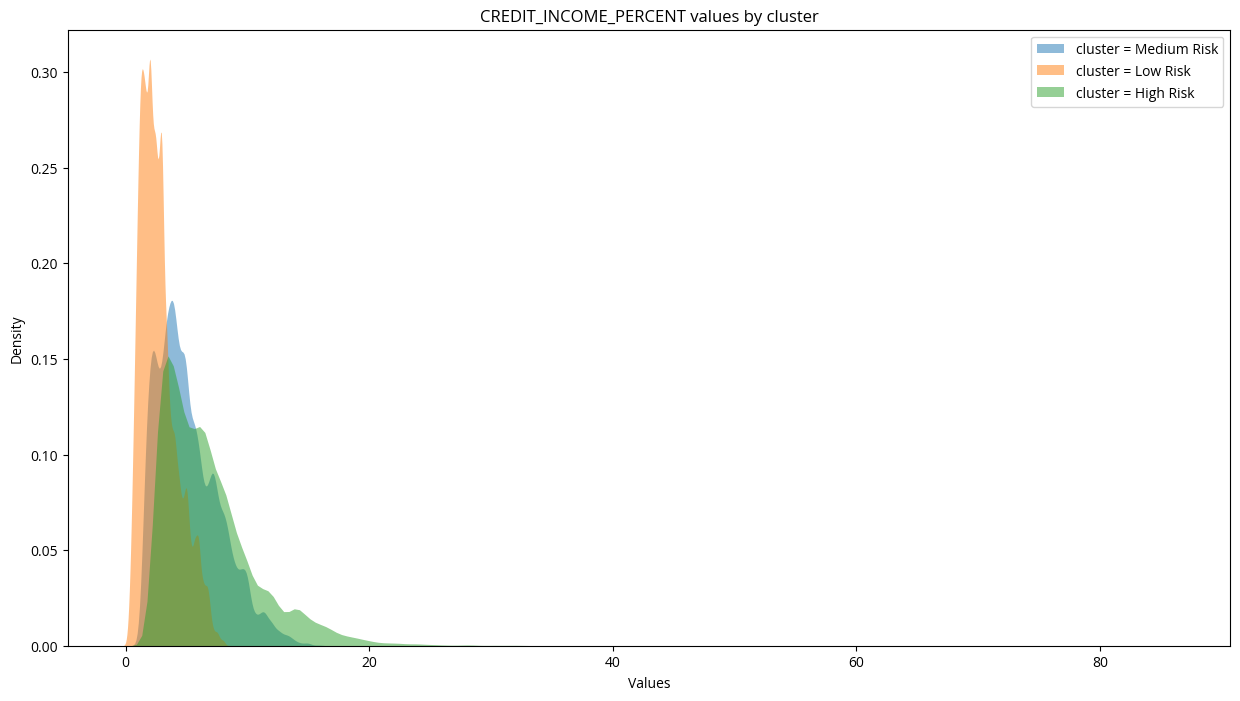

In [18]:
""" Plotting CREDIT_INCOME_PERCENT kde for different clusters """
helpers.plot_kde_for_clusters_by_col(X_train_final, "CREDIT_INCOME_PERCENT")

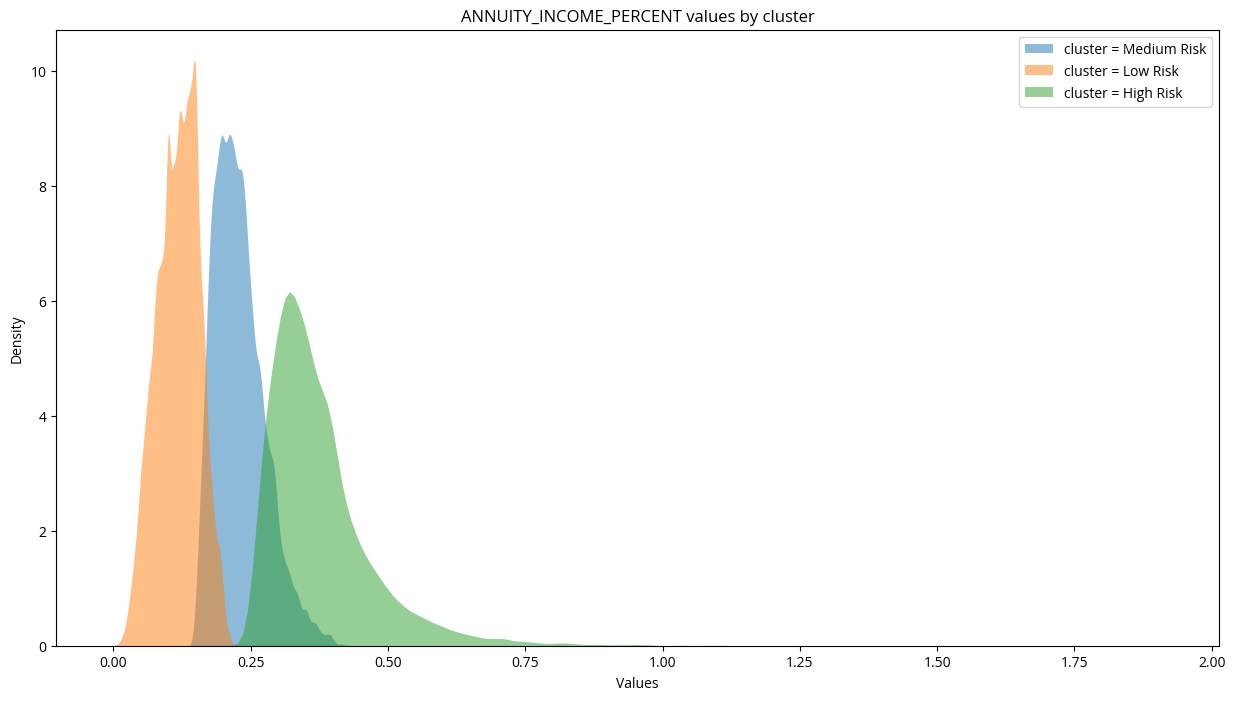

In [19]:
""" Plotting ANNUITY_INCOME_PERCENT kde for different clusters """
helpers.plot_kde_for_clusters_by_col(X_train_final, "ANNUITY_INCOME_PERCENT")

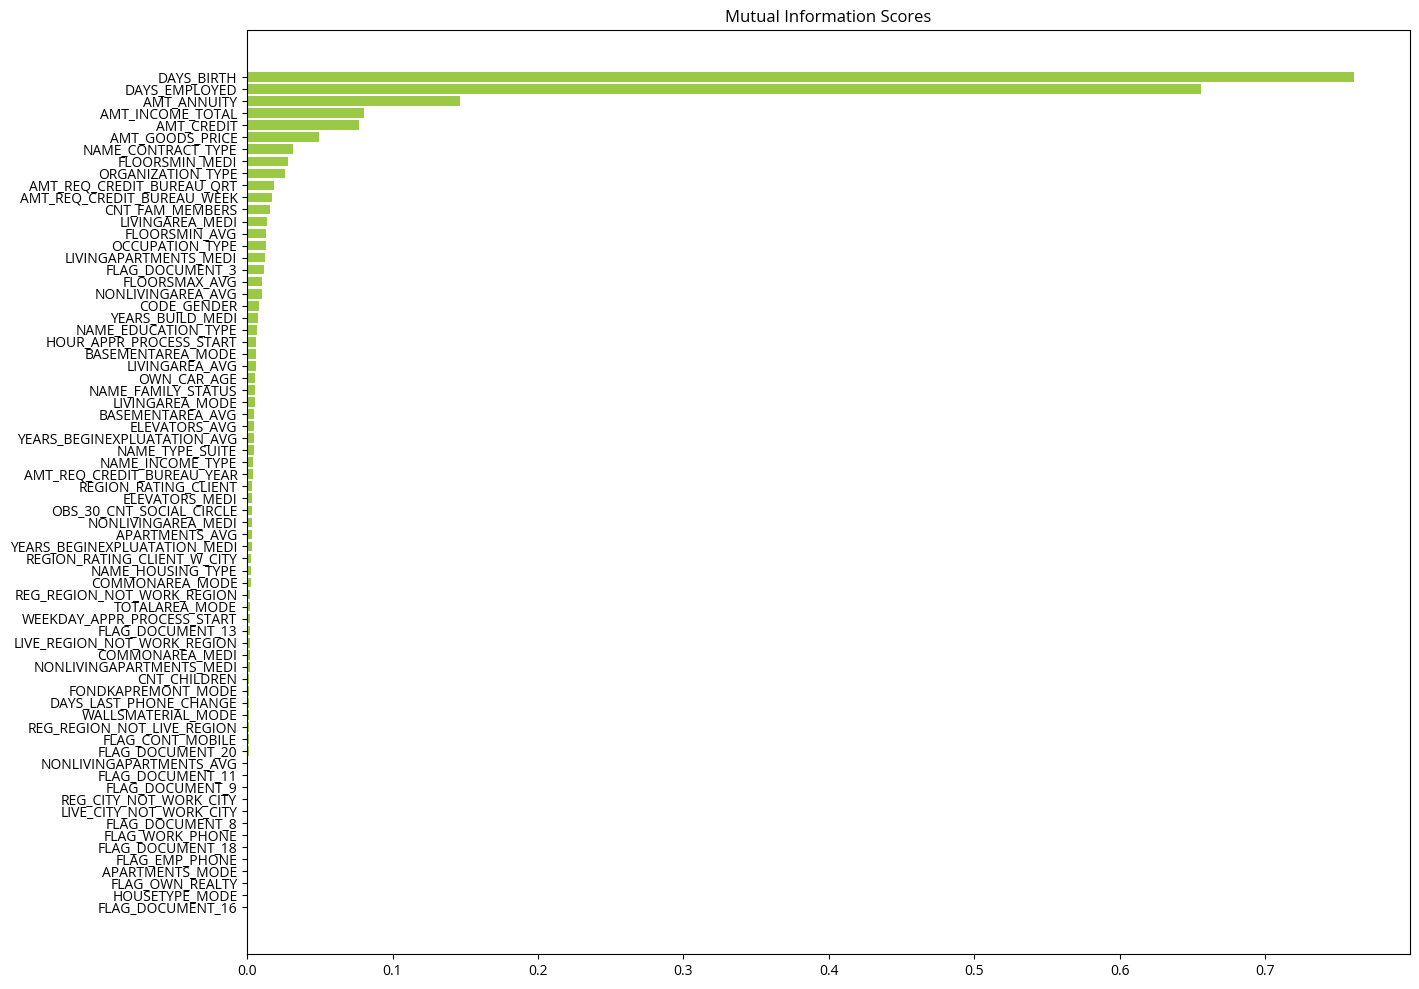

DAYS_BIRTH                   0.761214
DAYS_EMPLOYED                0.655746
AMT_ANNUITY                  0.146282
AMT_INCOME_TOTAL             0.080428
AMT_CREDIT                   0.076702
AMT_GOODS_PRICE              0.049193
NAME_CONTRACT_TYPE           0.031441
FLOORSMIN_MEDI               0.028361
ORGANIZATION_TYPE            0.025733
AMT_REQ_CREDIT_BUREAU_QRT    0.018610
Name: MI Scores, dtype: float64

In [27]:
""" Plotting mutual information with new is_fraud label """
df = X_train_final.sample(100000, random_state=42).copy()
mi_scores = helpers.get_and_plot_mi_scores(
    df[[col for col in X_train_final if col != "cluster" and "_ID_" not in col]],
    df[["cluster"]],
    "cluster",
)
mi_scores[:10]

In [20]:
""" Deploying models """
with open("cluster_assigner_preprocessor.pkl", "wb") as file:
    pickle.dump(final_preprocessor, file)

with open("cluster_assigner.pkl", "wb") as file:
    pickle.dump(kmeans, file)

encoder_model.save("encoder_model.h5")

## Deployed Application

#### Frontend Created with Streamlit: https://frontend-service-kx4s6cgoga-ew.a.run.app/
#### Backend Created with FastAPI: https://backend-service-kx4s6cgoga-lm.a.run.app/